# Auswertung des Datensatzes zu Autoverkäufen

# Bereinigung der einzelnen Datensätze

## Importieren der Datensätze und Pythonmodule

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

df_besucher = pd.read_csv('data/besucher.csv', decimal = ',', sep = ";")   
df_kunden = pd.read_csv('data/kunden.csv', decimal = '.', sep = ";")
df_geo = pd.read_csv('data/geo.txt', decimal = '.', delimiter = "\t")

### Bereinigung von df_geo

In [3]:
df_geo['Niederlassung'].value_counts()

Niederlassung
Baden-Württemberg        382
Bayern                   338
Nordrhein-Westfalen      322
Berlin                   230
Niedersachsen            169
Hessen                   165
Sachsen                  162
Thüringen                 89
Hamburg                   67
Brandenburg               60
NRW                        3
Düsseldorf                 2
Berlin-Charlottenburg      2
Berlin-Mitte               2
BERLIN                     2
Name: count, dtype: int64

In [4]:
#Ersetzen der fehlerhaften Orde durch die korrekten Bundesländer
df_geo['Niederlassung']=df_geo['Niederlassung'].replace({'NRW':'Nordrhein-Westfalen'})
df_geo['Niederlassung']=df_geo['Niederlassung'].replace({'Düsseldorf':'Nordrhein-Westfalen'})
df_geo['Niederlassung']=df_geo['Niederlassung'].replace({'Berlin-Charlottenburg':'Berlin'})
df_geo['Niederlassung']=df_geo['Niederlassung'].replace({'Berlin-Mitte':'Berlin'})
df_geo['Niederlassung']=df_geo['Niederlassung'].replace({'BERLIN':'Berlin'})
df_geo['Niederlassung'].value_counts()

Niederlassung
Baden-Württemberg      382
Bayern                 338
Nordrhein-Westfalen    327
Berlin                 236
Niedersachsen          169
Hessen                 165
Sachsen                162
Thüringen               89
Hamburg                 67
Brandenburg             60
Name: count, dtype: int64

### Bereinigung df_besucher (benötigt keine Bereinigung)

In [5]:
df_besucher.isnull().sum() #keine fehlenden Werte

Alter         0
Einkommen     0
Geschlecht    0
Zeit          0
KundeNr       0
dtype: int64

In [6]:
print(df_besucher[(29 >= df_besucher['Alter']) | (df_besucher['Alter'] >= 71)]) #keine unrealistischen Ausreißer
print(df_besucher[(1000 >= df_besucher['Einkommen']) | (df_besucher['Einkommen'] >= 200000)]) #keine unrealistischen Ausreißer
print(df_besucher[(1 >= df_besucher['Zeit']) | (df_besucher['Zeit'] >= 80)]) #keine unrealistischen Ausreißer

Empty DataFrame
Columns: [Alter, Einkommen, Geschlecht, Zeit, KundeNr]
Index: []
Empty DataFrame
Columns: [Alter, Einkommen, Geschlecht, Zeit, KundeNr]
Index: []
Empty DataFrame
Columns: [Alter, Einkommen, Geschlecht, Zeit, KundeNr]
Index: []


### Bereinigung df_kunden

In [7]:
df_kunden.isnull().sum() #5 fehlende Werte bei der Zeit

Alter         0
Einkommen     0
Preis         0
Geschlecht    5
Zeit          0
KundeNr       0
dtype: int64

In [8]:
geschlecht_modus = df_kunden['Geschlecht'].mode()[0] #Bestimmung des Modus beim Geschlecht
df_kunden['Geschlecht'] = df_kunden['Geschlecht'].fillna(geschlecht_modus) #fehlende Werte beim Geschlecht mit Modus ausfüllen
df_kunden.isnull().sum() #korrigiert

Alter         0
Einkommen     0
Preis         0
Geschlecht    0
Zeit          0
KundeNr       0
dtype: int64

In [9]:
print(df_kunden[(29 >= df_kunden['Alter']) | (df_kunden['Alter'] >= 71)]) #Alter braucht Korrektur
print(df_kunden[(1000 >= df_kunden['Einkommen']) | (df_kunden['Einkommen'] >= 100000)]) #Einkommen braucht Korrektur
print(df_kunden[(1 >= df_kunden['Zeit']) | (df_kunden['Zeit'] >= 80)]) #Zeit braucht keine Korrektur

     Alter  Einkommen      Preis  Geschlecht  Zeit KundeNr
142    100    88749.0  119134.23         0.0  64.0   K0494
711    120    61857.0  104214.07         1.0  52.0   K0039
      Alter     Einkommen      Preis  Geschlecht  Zeit KundeNr
366      62  1.007690e+05  125018.41         0.0  71.0   K0311
408      68  1.000000e+09   87209.72         0.0  52.0   K0701
834      68  1.076890e+05  165482.31         1.0  60.0   K0415
966      69  0.000000e+00  125140.05         1.0  65.0   K1021
1082     59 -6.284037e+04   92837.59         0.0  46.0   K1083
     Alter  Einkommen      Preis  Geschlecht  Zeit KundeNr
313     62    96569.0  140745.65         0.0  80.0   K0249


In [10]:
#Interquartilsabstand bestimmen
Q1_e = df_kunden['Einkommen'].quantile(0.25)
Q3_e = df_kunden['Einkommen'].quantile(0.75)
IQR_e = Q3_e - Q1_e
untere_grenze_e  = Q1_e - 1.5 * IQR_e
obere_grenze_e = Q3_e + 1.5 * IQR_e

#Ausreißer ermitteln. 
#Kunde mit Index 834 kein unrealistisches Einkommen mit ca 107.689€, obwohl außerhalb der Grenzen, deshalb aus Ausreißer entfernt.
df_kunden['Ausreißer'] = (df_kunden['Einkommen'] < untere_grenze_e) | (df_kunden['Einkommen'] > obere_grenze_e).drop(834)

#Einkommen der Ausreißer durch Medianwert ersetzt
df_kunden['Einkommen'].replace(list(df_kunden.loc[df_kunden['Ausreißer'] == True]['Einkommen']),
                               df_kunden['Einkommen'].median(), inplace = True)

#temporäre Spalte der Ausreißer wieder entfernen
df_kunden = df_kunden.drop('Ausreißer', axis = 1)

In [11]:
#Interquartilsabstand bestimmen
Q1_a = df_kunden['Alter'].quantile(0.25)
Q3_a = df_kunden['Alter'].quantile(0.75)
IQR_a = Q3_a - Q1_a
untere_grenze_a  = Q1_a - 1.5 * IQR_a
obere_grenze_a = Q3_a + 1.5 * IQR_a

#Ausreißer ermitteln. 
df_kunden['Ausreißer'] = (df_kunden['Alter'] < untere_grenze_a) | (df_kunden['Alter'] > obere_grenze_a)

#Alter der Ausreißer durch Medianwert ersetzt
df_kunden["Alter"].replace(list(df_kunden.loc[df_kunden["Ausreißer"] == True]["Alter"]),
                           df_kunden["Alter"].median(), inplace = True)

#temporäre Spalte der Ausreißer wieder entfernen
df_kunden = df_kunden.drop("Ausreißer", axis = 1)

In [12]:
print(df_kunden[(29 >= df_kunden['Alter']) | (df_kunden['Alter'] >= 71)]) #korrigiert
print(df_kunden[(1000 >= df_kunden['Einkommen']) | (df_kunden['Einkommen'] >= 200000)]) #korrigiert

Empty DataFrame
Columns: [Alter, Einkommen, Preis, Geschlecht, Zeit, KundeNr]
Index: []
Empty DataFrame
Columns: [Alter, Einkommen, Preis, Geschlecht, Zeit, KundeNr]
Index: []


### Zusammenführung von besucher.csv und kunden.csv

In [13]:
df_alle_ohneGEO = pd.concat([df_besucher,df_kunden], ignore_index=True,)
df_alle_ohneGEO_sortiert = df_alle_ohneGEO.sort_values(by=['KundeNr'],ascending=True).round(decimals=2)

df_alle_ohneGEO_sortiert

,Alter,Einkommen,Geschlecht,Zeit,KundeNr,Preis
1367,68,89437.00,1.0,62.0,K0001,114481.90
1783,58,65271.00,1.0,44.0,K0002,106258.99
1116,44,48195.00,1.0,29.0,K0003,85705.57
1065,37,48957.00,0.0,36.0,K0004,76412.36
1882,50,56621.00,0.0,40.0,K0005,92898.67
...,...,...,...,...,...,...
18,48,59967.31,1.0,21.0,K1991,NaN
799,67,81521.76,1.0,21.0,K1992,NaN
592,40,41616.57,0.0,48.0,K1993,NaN
72,49,76602.79,1.0,19.0,K1994,NaN


### Zusammenführung von geo.txt und df_alle_ohneGEO

In [14]:
df_final= pd.merge(df_alle_ohneGEO_sortiert,df_geo,on='KundeNr', how='outer').set_index('KundeNr')
df_final

,Alter,Einkommen,Geschlecht,Zeit,Preis,Niederlassung
KundeNr,,,,,,
K0001,68,89437.00,1.0,62.0,114481.90,Sachsen
K0002,58,65271.00,1.0,44.0,106258.99,Nordrhein-Westfalen
K0003,44,48195.00,1.0,29.0,85705.57,Hessen
K0004,37,48957.00,0.0,36.0,76412.36,Bayern
K0005,50,56621.00,0.0,40.0,92898.67,Bayern
...,...,...,...,...,...,...
K1991,48,59967.31,1.0,21.0,NaN,Hessen
K1992,67,81521.76,1.0,21.0,NaN,Baden-Württemberg
K1993,40,41616.57,0.0,48.0,NaN,Nordrhein-Westfalen


# Beantwortung unternehmensrelevanter Fragen

### F1 Wie viele Autos wurden verkauft?


In [15]:
print("Es wurden insgesamt " +str(len(df_kunden.index))+ " Autos verkauft.")

Es wurden insgesamt 1104 Autos verkauft.


### F2 Höchst-, Mindest- und Durchschnittspreis der verkauften Autos

In [16]:
df_max_preis = df_final['Preis'].max()
df_min_preis = df_final['Preis'].min()
df_mean_preis = df_final['Preis'].mean().round(2)
print(f""" Der maximale Betrag für einen Autokauf betrug {df_max_preis}€.
 Der minimale Betrag für einen Autokauf betrug {df_min_preis}€.
 Der Durchschnittspreis betrug {df_mean_preis}€.""")

 Der maximale Betrag für einen Autokauf betrug 165482.31€.
 Der minimale Betrag für einen Autokauf betrug 21471.65€.
 Der Durchschnittspreis betrug 88975.2€.


### F3 Wie hoch war der Gesamtumsatz?

In [28]:
Gesamtumsatz = df_final['Preis'].sum()
print("Der Gesamtumsatz lag bei EUR "+str(Gesamtumsatz))

Der Gesamtumsatz lag bei EUR 98228619.38


### F4 Wie viele Autos wurden pro Bundesland verkauft?

In [29]:
df_sold = df_final[df_final['Preis'].notnull()]
sales_per_state = df_sold['Niederlassung'].value_counts()
print(sales_per_state)

Niederlassung
Baden-Württemberg      205
Bayern                 188
Nordrhein-Westfalen    175
Berlin                 126
Hessen                  96
Niedersachsen           96
Sachsen                 89
Thüringen               49
Hamburg                 43
Brandenburg             37
Name: count, dtype: int64


### F5 durchschnittlicher Umsatz pro Bundesland

In [30]:
#Liste aller vertretenen Bundesländer erstellen
bundesländer = df_final['Niederlassung'].unique() #np.array-Format, wobei das nicht wichtig ist!

#Liste des durchschnittlichen Umsatzes erstellen
mean_rev_bl = []

for i in bundesländer:
    mean_rev_bl.append(df_final.loc[df_final.Niederlassung == i, "Preis"].mean().round(2))

#Tabelle mit Bundesländern und durchschnittlichen Umsatz 
mean_rev_bl_series = pd.Series(mean_rev_bl, name = 'durchschnittlicher Umsatz in Euro')
df_mean_rev_bl = mean_rev_bl_series.to_frame().set_index(bundesländer).sort_values(
    'durchschnittlicher Umsatz in Euro', ascending = False) #sortiert nach dem durchschnittlichen Umsatz
df_mean_rev_bl

,durchschnittlicher Umsatz in Euro
Baden-Württemberg,90969.56
Thüringen,90816.99
Berlin,89584.98
Sachsen,89455.08
Bayern,89344.31
Nordrhein-Westfalen,88633.27
Niedersachsen,87963.31
Brandenburg,86673.64
Hessen,85864.93
Hamburg,85549.50


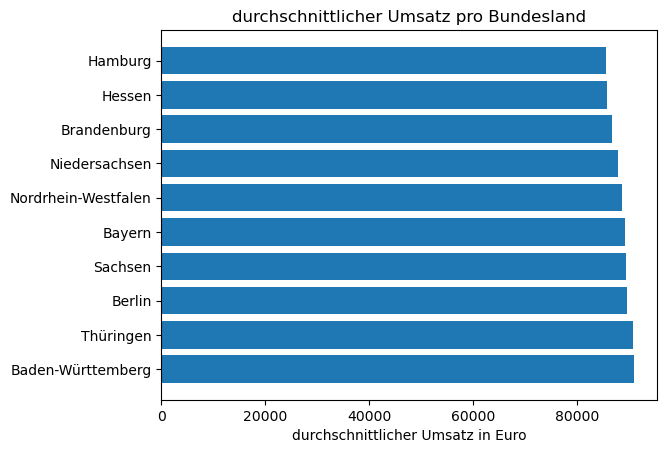

In [31]:
plt.barh(df_mean_rev_bl.index, df_mean_rev_bl['durchschnittlicher Umsatz in Euro'])
plt.title ("durchschnittlicher Umsatz pro Bundesland")
plt.xlabel('durchschnittlicher Umsatz in Euro')
plt.show()

### F6 In welchem Bundesland wurde das teuerste Auto verkauft?

In [32]:
# Finde Index des Kunden mit maximalen Preis
index_MaxPreis = df_final['Preis'].idxmax()
#Print output
print("Das teuerste Auto wurde in "+str(df_final.loc[index_MaxPreis]['Niederlassung'])+ " verkauft.")

Das teuerste Auto wurde in Niedersachsen verkauft.


### F7 Haben mehr Frauen oder Männer ein Auto gekauft?

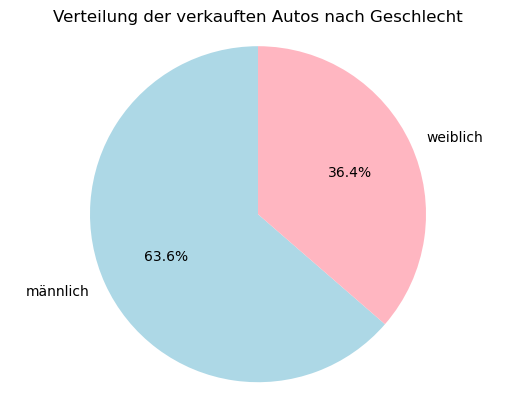

In [33]:
geschlecht_vergleich = df_kunden["Geschlecht"].value_counts()
labels = ["männlich", "weiblich"]
sizes = [700,400]
colors = ["lightblue","lightpink"]
plt.pie(sizes, labels = labels, colors = colors, autopct = "%1.1f%%", startangle = 90)
plt.axis("equal")
plt.title("Verteilung der verkauften Autos nach Geschlecht")
plt.show()



### F8 Durchschnittsalter der Kunden und Besucher

In [34]:
print(f"""Die Kunden sind durchschnittlich {df_kunden['Alter'].mean().round(2)} Jahre alt.
Die Besucher sind durchschnittlich {df_besucher['Alter'].mean().round(2)} Jahre alt.""")

Die Kunden sind durchschnittlich 50.38 Jahre alt.
Die Besucher sind durchschnittlich 49.88 Jahre alt.


### F9 Durchschnittseinkommen der Kunden und Besucher

In [35]:
print(f"""Die Kunden haben ein durchschnittliches Einkommen von {df_kunden['Einkommen'].mean().round(2)} Euro.
Die Besucher haben ein durchschnittliches Einkommen von {df_besucher['Einkommen'].mean().round(2)} Euro.""")

Die Kunden haben ein durchschnittliches Einkommen von 58895.0 Euro.
Die Besucher haben ein durchschnittliches Einkommen von 59367.94 Euro.


### F10 Gibt es einen statistisch signifikanten Unterschied zwischen dem Durchschnittseinkommen der Kunden und dem der Besucher?

t-Statistik: -0.6435124185848957
p-Wert: 0.5199684784519678
Wir können die Nullhypothese nicht ablehnen. Es gibt keinen signifikanten Unterschied im Durchschnittseinkommen.


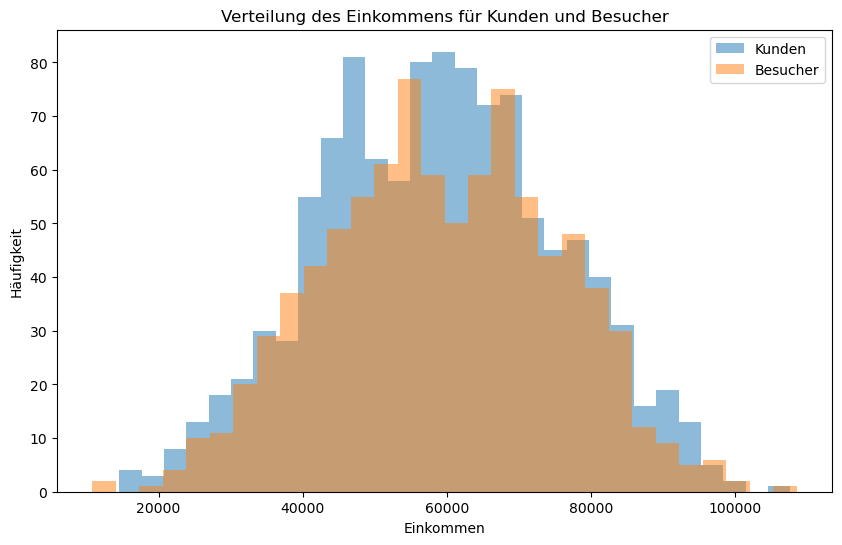

In [36]:
# t-Test 
t_stat, p_val = stats.ttest_ind(df_kunden["Einkommen"].dropna(), df_besucher["Einkommen"].dropna(), equal_var=False)
t_stat, p_val

print("t-Statistik:", t_stat)
print("p-Wert:", p_val)

alpha = 0.05
if p_val < alpha:
    print("Wir lehnen die Nullhypothese ab. Es gibt einen signifikanten Unterschied im Durchschnittseinkommen.")
else:
    print("Wir können die Nullhypothese nicht ablehnen. Es gibt keinen signifikanten Unterschied im Durchschnittseinkommen.")
    
plt.figure(figsize=(10, 6))
plt.hist(df_kunden["Einkommen"].dropna(), alpha=0.5, label='Kunden', bins=30)
plt.hist(df_besucher["Einkommen"].dropna(), alpha=0.5, label='Besucher', bins=30)
plt.xlabel('Einkommen')
plt.ylabel('Häufigkeit')
plt.title('Verteilung des Einkommens für Kunden und Besucher')
plt.legend(loc='upper right')
plt.show()

### F11 Korrelation zwischen Alter, Einkommen, Preis und Zeit

In [37]:
correlation = df_kunden[['Alter', 'Einkommen', 'Preis', 'Zeit']].corr().round(6)
correlation

,Alter,Einkommen,Preis,Zeit
Alter,1.000000,0.761553,0.780478,0.588912
Einkommen,0.761553,1.000000,0.896557,0.776198
Preis,0.780478,0.896557,1.000000,0.707778
Zeit,0.588912,0.776198,0.707778,1.000000


### F12  Mit Hilfe eines qq-Plots testen, ob die Variable Zeit approximativ normalverteilt ist

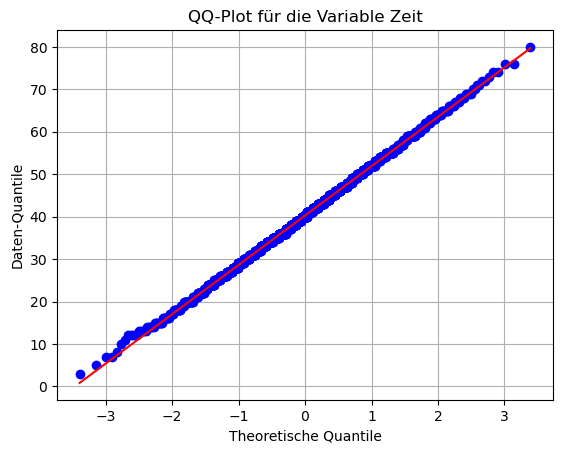

Basierend auf obenstehender Grafik, ist anzunehmen, dass die Variable Zeit approximativ normalverteilt ist.


In [38]:
#Plot definieren
stats.probplot(df_final['Zeit'], dist="norm", plot=plt)
#Diverse Label vergeben
plt.title('QQ-Plot für die Variable Zeit')
plt.xlabel('Theoretische Quantile')
plt.ylabel('Daten-Quantile')
plt.grid(True)
#Plot und Feststellung ausgeben
plt.show()
print("Basierend auf obenstehender Grafik, ist anzunehmen, dass die Variable Zeit approximativ normalverteilt ist.")

### F13 Schätzung der Anzahl der Kunden, welche einen Bankkredit aufnehmen mussten

In [39]:
#Gibt Summe der Zeilen aus, auf die Zutrifft, dass Preis >= dem Einkommen ist.
print("Die Anzahl der Kunden, die einen Kredit aufnehmen mussten ist " + str(sum((df_kunden['Preis'] >= df_kunden['Einkommen'])))+".")

Die Anzahl der Kunden, die einen Kredit aufnehmen mussten ist 1099.


### F14 Einfluss sozioökonomischer Merkmale auf den Kaufpreis

                            OLS Regression Results                            
Dep. Variable:                  Preis   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     1329.
Date:                Wed, 26 Jun 2024   Prob (F-statistic):               0.00
Time:                        20:46:32   Log-Likelihood:                -11748.
No. Observations:                1104   AIC:                         2.351e+04
Df Residuals:                    1099   BIC:                         2.353e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -130.1040   1532.387     -0.085      0.9

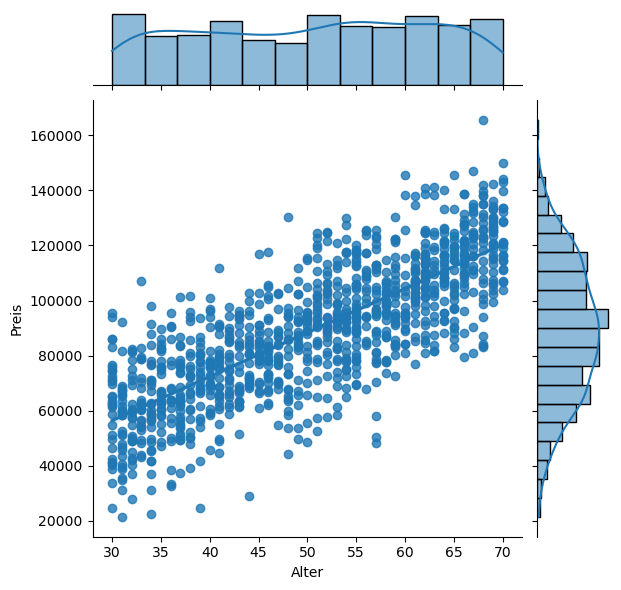

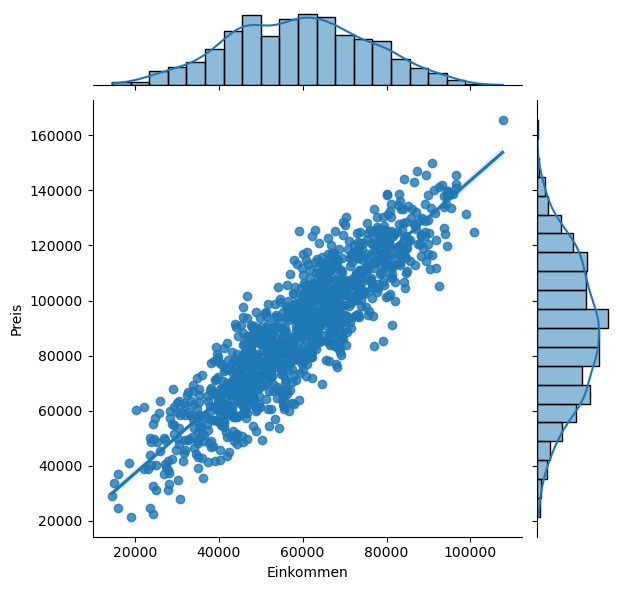

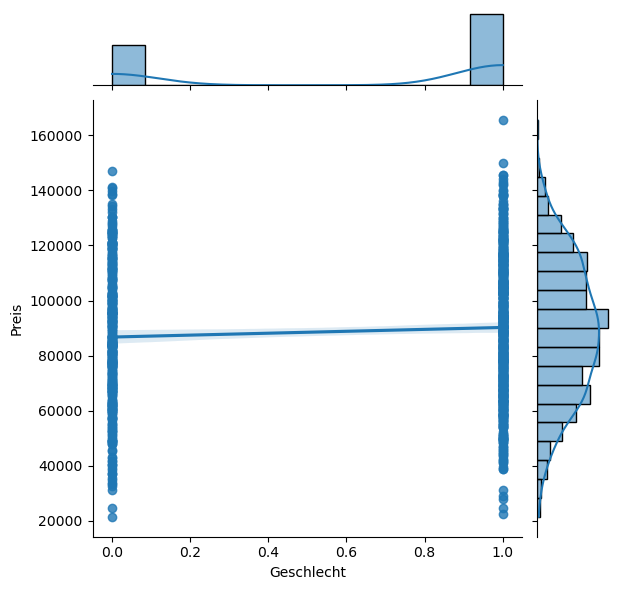

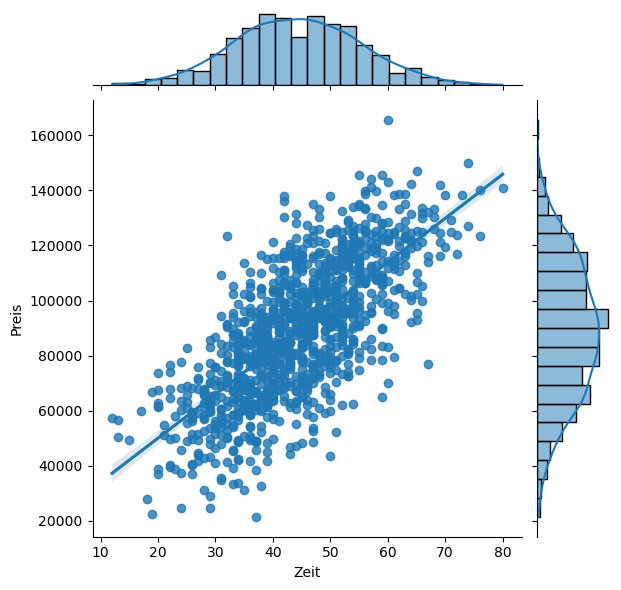

In [40]:
#unabhängige Variablen (Alter, Einkommen, Geschlecht, Zeit) und eine Konstante
XVar_without_const = df_kunden.drop(["Preis", "KundeNr"], axis = 1)
XVar = sm.add_constant(XVar_without_const)

#abhängige Variable (Preis)
YVar = df_kunden["Preis"]

#Modell zur linearen Regression nach der Methode der kleinsten Quadrate
linearModel1 = sm.OLS(YVar, XVar).fit()
print(linearModel1.summary())

#zusätzliche Regressionsgraphen der abhängigen Variable in Bezug auf die einzelnen unabhängigen Variablen
print(sns.jointplot(x = df_kunden["Alter"], y = df_kunden["Preis"], kind = "reg"))
print(sns.jointplot(x = df_kunden["Einkommen"], y = df_kunden["Preis"], kind = "reg"))
print(sns.jointplot(x = df_kunden["Geschlecht"], y = df_kunden["Preis"], kind = "reg"))
print(sns.jointplot(x = df_kunden["Zeit"], y = df_kunden["Preis"], kind ="reg"))

### F15 Prognose des Kaufpreises spezifischer Kundentypen

#### 1.

In [41]:
Kaufpreis1 = linearModel1.params[0]+linearModel1.params[1]*32+linearModel1.params[2]*30000+linearModel1.params[3]*1
print("Der durchschnittliche Kaupfreis eines Autos für einen männlichen Kunden, der 32 Jahre alt ist und 30.000 Euro verdient ist: "+ str(Kaufpreis1.round(2)))

Der durchschnittliche Kaupfreis eines Autos für einen männlichen Kunden, der 32 Jahre alt ist und 30.000 Euro verdient ist: 48128.08


#### 2.

In [42]:
Kaufpreis2 = linearModel1.params[0]+linearModel1.params[1]*51+linearModel1.params[2]*54000+linearModel1.params[3]*1
print("Der durchschnittliche Kaupfreis für einen männlichen Kunden, der 51 Jahre alt ist und 54.000 Euro verdient ist: "+ str(Kaufpreis2.round(2)))

Der durchschnittliche Kaupfreis für einen männlichen Kunden, der 51 Jahre alt ist und 54.000 Euro verdient ist: 81856.29


### F16 Bestimmung der Variable, die den Kaufpreis am stärksten beeinflusst

In [43]:
#Definieren der unabhängigen Variablen
features = ['Alter', 'Einkommen', 'Geschlecht', 'Zeit']
#Definieren der abhängigen Variablen
target = 'Preis'
X = df_kunden[features]
y = df_kunden[target]

#Standardisierung
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_standardized = scaler_X.fit_transform(X)
y_standardized = scaler_y.fit_transform(y.values.reshape(-1, 1))
#LineareRegression mit standardisierten Koeffizienten
model = LinearRegression()
model.fit(X_standardized, y_standardized)

standardized_coefficients = model.coef_

print("Standardisierte Regressionskoeffizienten:", standardized_coefficients)
print("Der voraussichtliche Kaufpreis wird am stärksten durch das Einkommen des potenziellen Kunden beeinflusst.")

Standardisierte Regressionskoeffizienten: [[0.23440395 0.69202979 0.04200928 0.03167945]]
Der voraussichtliche Kaufpreis wird am stärksten durch das Einkommen des potenziellen Kunden beeinflusst.


### F17 Modell zur Wahrscheinlichkeit des Kaufs eines Autos

In [44]:
#Erstellung einer Spalte in der Tabelle mit 1="Kauf" und 0="kein Kauf"
df_final["Kauf"] = (df_final["Preis"] / df_final["Preis"]).fillna(0)

#unabhängige Variablen (Alter, Einkommen, Geschlecht, Zeit) und eine Konstante
X_log_reg_without_const = df_final.drop(["Kauf", "Niederlassung", "Preis"], axis = 1)
X_log_reg = sm.add_constant(X_log_reg_without_const)

#abhängige Variable (Kauf)
Y_log_reg = df_final["Kauf"]

#Modell zur logistischen Regression
model_lg = sm.Logit(Y_log_reg, X_log_reg).fit()
print(model_lg.summary())

Optimization terminated successfully.
         Current function value: 0.579007
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                   Kauf   No. Observations:                 1995
Model:                          Logit   Df Residuals:                     1990
Method:                           MLE   Df Model:                            4
Date:                Wed, 26 Jun 2024   Pseudo R-squ.:                  0.1577
Time:                        20:46:36   Log-Likelihood:                -1155.1
converged:                       True   LL-Null:                       -1371.4
Covariance Type:            nonrobust   LLR p-value:                 2.465e-92
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.4426      0.263     -9.270      0.000      -2.959      -1.926
Alter          0.0180      0.

### F18 Wahrscheinlichkeit des Kaufs eines Autos spezifischer Kundentypen

In [45]:
ErsterKunde_predict = pd.DataFrame({'Alter': [32],
                                   'Einkommen': [30000],
                                   'Geschlecht':[1],
                                   'Zeit':[30]})
ErsterKunde_predict = sm.add_constant(ErsterKunde_predict,has_constant='add')
ErsterKunde_prob = model_lg.predict(ErsterKunde_predict)

ZweiterKunde_predict = pd.DataFrame({'Alter': [51],
                                   'Einkommen': [54000],
                                   'Geschlecht':[1],
                                   'Zeit':[45]})
ZweiterKunde_predict = sm.add_constant(ZweiterKunde_predict,has_constant='add')
ZweiterKunde_prob = model_lg.predict(ZweiterKunde_predict)

ErsterKunde_prob_proz = ErsterKunde_prob[0]*100
ZweiterKunde_prob_proz = ZweiterKunde_prob[0]*100

print(f"{ErsterKunde_prob_proz.round(5)}%")
print(f"{ZweiterKunde_prob_proz.round(5)}%")

54.57104%
74.03834%


### F19 Probleme und Prozess des Zusammenführens und Bereinigen der Daten

Zunächst mussten wir beim Einlesen der Dateien auf die richtige Vergabe der Dezimalzeichen achten, da diese bei den Datensätzen
unterschiedlich waren. Auch das Definieren der Spalten war für jeden Datensatz unterschiedlich.

Bei der Bereinigung fanden wir es zunächst schwierig, zu identifizieren, welche Spalten und Werte genau bererinigt werden müssen. Die Bereinigung für den Datensatz geo.txt wurde nach der Identifiezierung der falschen Begriffe
letzendlich durch den replace-Befehl durchgeführt.
Für die Kundendatei haben wir uns Intervalle definiert, die Ausreißer anzeigen sollten.
Hier musste beim Einkommen ein Kunde der ein Ausreißer war, jedoch als realistisch zu betrachten war,
extra berücksichtigt werden. Die restlichen Ausreißer wurden durch den Median der jeweiligen Kategorie ersetzt.

Zusammengefügt hatten wir dann die beiden Dateien mit den Besuchern und den Kunden. Mit Concat haben wir die Besucherdatei
an die Kundendatei gehängt. Wir haben explizit die Besucher an die Kunden gehängt, da dann die Werte für den Preis als n/a
definiert werden. Im zweiten Schritt haben wir die Datei mit Verkaufsdaten anhand der Kundennummer aufsteigend sortiert.
Dann wurde mit Merge, unter Beachtung, dass das Zusammenfügen anhand der Kundennummer passiert, die Geo Daten mit den
restlichen Daten vereint. So tauchte die Spalte KundeNr nicht doppelt auf.
Im letzten Schritt haben wir übersichtshalber nocht die Spalte mit den kundennummern als Index definiert.

### F20 Vorschläge an die Kundenabteilung für die Umfrage im nächsten Jahr

Ein einheitliches System der Benennung und der Datensammlung würde den Prozess der Datenanalyse vereinfachen. So sollten beispielsweise die Datensätze für Kunden und Besucher nicht durch unterschiedliche Dezimalzeichen getrennt werden und einheitliche Benennungen der Orte festgelegt werden.
Eine interessante Information die den Autokauf noch beeinflüssen könnte und im Fragebogen vermerkt werden könnte wäre noch die 
Beratungsintensität

# Datei speichern

In [46]:
# df_final.to_csv('data/df_final.csv')

In [47]:
# df_kunden.to_csv('data/df_kunden.csv')

In [48]:
# df_besucher.to_csv('data/df_besucher.csv')